✔ Para desaparecimento de gradientes:

Usamos 5 camadas densas com ativação Sigmoid.
Taxa de aprendizado baixa (0.01).
Inicialização padrão (Glorot/Xavier).
Esperamos que os gradientes das primeiras camadas fiquem próximos de zero.

✔ Para explosão de gradientes:

Usamos Tanh, que pode gerar gradientes grandes se os pesos forem ruins.
Definimos uma inicialização personalizada que gera valores grandes (stddev=5).
Taxa de aprendizado muito alta (1.0).
Esperamos que os gradientes fiquem extremamente grandes.


=== DESAPARECIMENTO ===
Camada bias - Gradiente médio: 0.00020190398208796978
Camada bias - Gradiente médio: 0.0010187525767832994
Camada bias - Gradiente médio: 0.0020869201980531216
Camada bias - Gradiente médio: 0.0041392529383301735
Camada bias - Gradiente médio: 0.009064081124961376
Camada bias - Gradiente médio: 0.018187744542956352
Camada bias - Gradiente médio: 0.0388760045170784
Camada bias - Gradiente médio: 0.07726223021745682
Camada bias - Gradiente médio: 0.16584640741348267
Camada bias - Gradiente médio: 0.32568973302841187
Camada bias - Gradiente médio: 3.366197109222412
Camada bias - Gradiente médio: 6.73818826675415

=== EXPLOSAO ===
Camada bias - Gradiente médio: 3.7686939239501953
Camada bias - Gradiente médio: 24.97937774658203
Camada bias - Gradiente médio: 1.7753942012786865
Camada bias - Gradiente médio: 1.7524069547653198
Camada bias - Gradiente médio: 0.22539809346199036
Camada bias - Gradiente médio: 0.22438129782676697
Camada bias - Gradiente médio: 0.032701

<Figure size 1200x500 with 0 Axes>

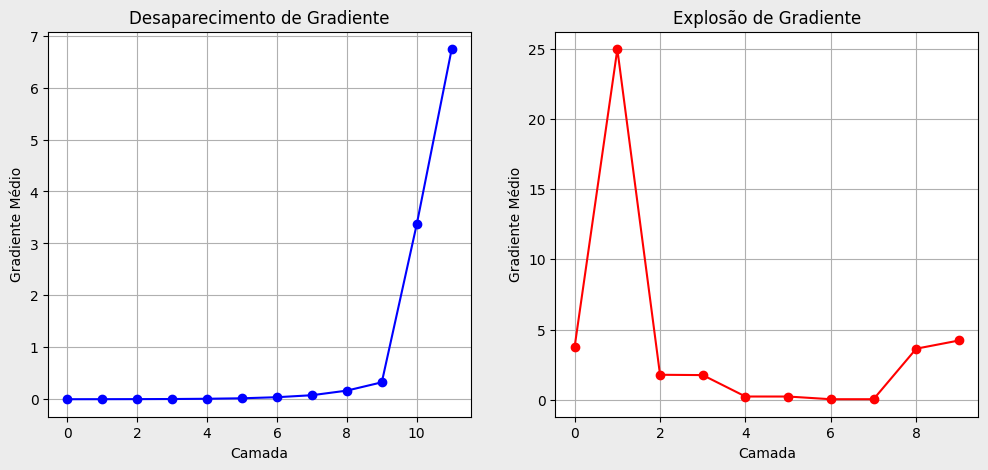

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

# Carregar dataset MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalizar os valores dos pixels para [0,1] (necessário para Sigmoid)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape(-1, 28 * 28)  # Transformar imagens em vetores
x_test = x_test.reshape(-1, 28 * 28)

# Converter rótulos para one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Função para inicialização ruim (valores grandes)
def bad_init(shape, dtype=None):
    return tf.random.normal(shape, mean=0, stddev=5, dtype=dtype)  # Pesos muito grandes

# Criando dois modelos: um para desaparecimento e outro para explosão
models = {}

### Modelo para desaparecimento de gradiente (Deep Sigmoid)
models["desaparecimento"] = Sequential([
    Dense(512, activation='sigmoid', input_shape=(28 * 28,)),
    Dense(512, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
    Dense(10, activation='softmax')
])

models["desaparecimento"].compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])

### Modelo para explosão de gradiente (Deep Tanh + inicialização ruim)
models["explosao"] = Sequential([
    Dense(512, input_shape=(28 * 28,), kernel_initializer=bad_init),  # Inicialização ruim
    Activation('tanh'),
    Dense(512, kernel_initializer=bad_init),
    Activation('tanh'),
    Dense(512, kernel_initializer=bad_init),
    Activation('tanh'),
    Dense(512, kernel_initializer=bad_init),
    Activation('tanh'),
    Dense(10, activation='softmax')
])

models["explosao"].compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2.0),  # Taxa de aprendizado alta
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Aplicando GradientTape() para calcular os gradientes no início do treinamento
gradients_data = {"desaparecimento": [], "explosao": []}

for tipo, model in models.items():
    with tf.GradientTape() as tape:
        predictions = model(x_train[:128])  # Pequena amostra
        loss = tf.keras.losses.categorical_crossentropy(y_train[:128], predictions)

    # Obter os gradientes
    gradients = tape.gradient(loss, model.trainable_variables)

    grad_values = []
    print(f"\n=== {tipo.upper()} ===")
    for grad in gradients:
        if grad is not None:
            grad_values.append(tf.reduce_mean(tf.abs(grad)).numpy())
            print(f"Camada {model.trainable_variables[i].name} - Gradiente médio: {tf.reduce_mean(tf.abs(grad)).numpy()}")

    gradients_data[tipo] = grad_values

# Gerando os gráficos
plt.figure(figsize=(12, 5))

# Criando o fundo personalizado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.patch.set_facecolor('#ECECEC')  # Define a cor de fundo do gráfico


# Gráfico do desaparecimento de gradiente
plt.subplot(1, 2, 1)
plt.plot(gradients_data["desaparecimento"], marker='o', linestyle='-', color='blue')
#plt.yscale("log")  # Escala logarítmica para visualizar melhor os pequenos valores
plt.title("Desaparecimento de Gradiente")
plt.xlabel("Camada")
plt.ylabel("Gradiente Médio")
plt.grid()

# Gráfico da explosão de gradiente
plt.subplot(1, 2, 2)
plt.plot(gradients_data["explosao"], marker='o', linestyle='-', color='red')
#plt.yscale("log")  # Escala logarítmica para capturar grandes variações
plt.title("Explosão de Gradiente")
plt.xlabel("Camada")
plt.ylabel("Gradiente Médio")
plt.grid()

# Mostrar os gráficos
plt.show()